# Unsupervised Learning on Wholesale Distribution

In this project we will analyze wholesale customer data on its internal structure. The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). 

For this project, we'll analyze the annual spending amounts of 440 clients of a wholesale distributor.

Spending amounts are provided for the following categories: 
*  Fresh: annual spending (m.u.) on fresh products (Continuous) 
*  Milk: annual spending (m.u.) on milk products (Continuous) 
*  Grocery: annual spending (m.u.) on grocery products (Continuous) 
*  Frozen: annual spending (m.u.) on frozen products (Continuous) 
*  Detergents_Paper: annual spending (m.u.) on detergents and paper products (Continuous) 
*  Delicatessen: annual spending (m.u.) on and delicatessen products (Continuous)

Using this information, we'll attempt to segment the clients into groups of similar clients.

For the initial part of the analysis, the features 'Channel' and 'Region' will be excluded with focus instead on the six product categories recorded for customers.



We will conduct the following steps in order to gather information about the internal structure of the data set:

* Data Analysis
* Gathering Domain Knowledge
* Determining Feature Relevance
* Investigate Data Distribution and Correlation
* Preprocessing and Data Scaling
* Outlier Detection
* Principal Component Analysis
* Clustering

Parts of this code were taken from this [S1](https://github.com/bcho018/Customer_segments_machine_learning/blob/master/customer_segments.ipynb).Also, to support supplementary visualizations need to run the visuals.py file which was influenced by the scripts from this [S2](https://github.com/teddyroland/python-biplot)


In [19]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from IPython.display import display # To allow the use of display() for DataFrames

import visuals as vs #S2 

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print ("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print ("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
After loading the data, let's do a little exploration to try and get an idea for what information is in this dataset through visualizations by observing a statistical description to understand how each feature is related to the others in order to consider what each category represents in terms of products you could purchase.

In [20]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis we selected a few sample data points and explored them in more detail. We tried different sets of samples until we obtained customers that vary significantly from one another.

In [21]:
#These three customers/indices vary significantly from one another after random sampling(S1)
indices = [23,42,127]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys(),index= indices)
print ("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,26373,36423,22019,5154,4337,16523
42,10850,7555,14961,188,6899,46
127,21465,7243,10685,880,2386,2749


### Manual Segmentation

What kind of establishment (customer) could each of the three samples chosen represent? 

Total purchase of Customer 23 :  110829
Total purchase of Customer 42 :  40499
Total purchase of Customer 127 :  45408


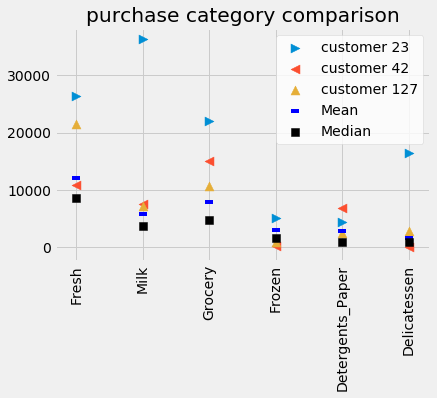

In [35]:
plt.style.use('fivethirtyeight') # Own logic

labels = 'Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper','Delicatessen'
sizes1 = [26373,36423,22019,5154,4337,16523] 
sizes2 = [10850,7555,14961,188,6899,46]
sizes3 = [21465,7243,10685,880,2386,2749]
mean = [12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455]
median = [8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000]

print ("Total purchase of Customer 23 : ", sum(sizes1))
print ("Total purchase of Customer 42 : ", sum(sizes2))
print ("Total purchase of Customer 127 : ", sum(sizes3))

x = np.arange(0,6,1)

c1=plt.scatter(x, sizes1, s=80, marker='>',label = 'customer 23')

c2=plt.scatter(x, sizes2, s=80, marker='<', label = 'customer 42')

c3=plt.scatter(x, sizes3, s=80, marker='^', label = 'customer 127')

c4=plt.scatter(x, mean, s=80, marker='_', color = 'b', label = 'Mean')

c5=plt.scatter(x, median, s=80, marker=',',color = 'k', label = 'Median')

plt.legend(handles=[c1,c2,c3,c4,c5],frameon=True,facecolor='w')
plt.xticks(x, labels, rotation='vertical')
plt.title("purchase category comparison")
plt.show()


Customer 23: This customer seems to be the largest of the three. All purchasing categories are in the upper 75% quantile and way above each category's median. This store spends an exceptionally high amount of money on products from the Milk, Fresh and Delicatessen categories. The most interesting piece of information is the high amount of Milk this customer purchases. It could represent a retailer or market that includes a broad palette of dairy products. The purchase amounts in the product categories Delicatesen, Fresh and Milk tend to indicate that this customer sells fresh organic high-end products with a specialty interest in Milk products. Based on its sortiment it is most likely a store that has a focus on mid- to upper-end customers.

Customer 42: Customer 42's yearly purchases in the categories Detergents_Paper, Fresh, Grocery and Milk are way above the median. In fact, Detergents, Grocery and Milk purchases are located in the 75% quantile. Frozen lower 25 % quantile, Detergrens 75% quantile, Delicatessen low 25% quantile. With almost no product in Delicatessen and Frozen this customer seems to focus on a narrow category selection, like a corner store that's lacking space and technology for frozen products as well as a delicatessen counter.

Customer 127: Customer 127 focuses on Fresh produce, Milk and Groceries (all 75% quantile) which indicates that we're looking at a joint that's able to turn a lot of fresh produce into profit in a small amount of time like a restaurant or a fresh produce market. The above median amount in Delicatessen and the below median amount in Frozen products indicate that there are some high-margin elements on the menu and the joint ist more likely to produce fresh meals.

### Feature Relevance
Trying to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We are trying to find feature relevance by training a supervised regression algorithm with one feature removed, and then score how well that model can predict the removed feature.

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression 
from sklearn import cross_validation

# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.copy().drop('Detergents_Paper', 1)

# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Detergents_Paper'], test_size=0.25, random_state=0)

#Create shuffle split sets using cross validation
cv_sets = cross_validation.ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.25, random_state = 0)

# Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print ("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))



Model has a coefficient of determination, R^2, of 0.729.


c:\users\sanke\miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
from sklearn import linear_model # Implemented our own logic below
regressor1 = linear_model.LinearRegression() 
regressor1.fit(X_train,y_train)
pred1 = regressor1.predict(X_test)
regressor1.score(X_test,y_test,pred1)

0.8515606536360533

Tried to predict annual spending on detergents and paper products and got a R^2 score of 0.729 using decision tree and R^2 score of 0.851 for Linear regression . This model performs predictions on this feature quite well, so it's not absolutely necessary that we need this feature to identify customers' spending habits.

### Visualize Feature Distributions
To get a better understanding of our features and how they're related, we'll plot a scatter matrix of the six spending categories. This shows the distribution of values for a given feature and the correlation between features.



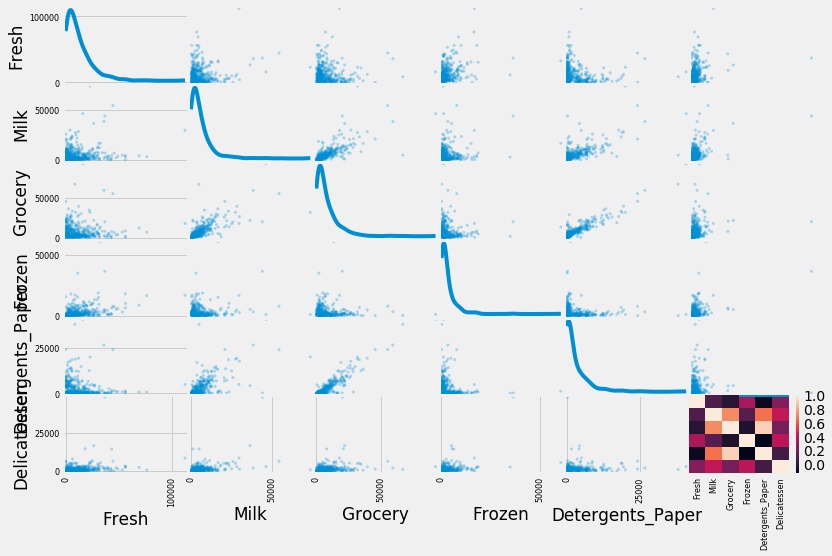

In [37]:
# Produce a scatter matrix for each pair of features in the data #S1
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (12,8), diagonal = 'kde');

from seaborn import heatmap #Own code
ax= heatmap(data.corr())

`Detergents_Paper` appears to be somewhat correlated with `Milk` and rather highly correlated with `Grocery`. All features appear to have a heavily positively skewed distribution.

* There are a large number of data points near 0, however this would be caused by the outliers. If we were to remove the outliers, the data would distribute itself more cleanly. We would see more points distributed more normally than before.
* Grocery and Detergents_Paper seem to have some correlation. Grocery and Milk also have some correlation. Milk and Detergents_Paper also seems to have some correlation.
* This helps confirm my suspicion about the relevance of Frozen. Frozen seems to not correlate with any of the other features
* The data is a Right-Skewed Distribution, as most of the data lies on the left. Typically, spending in each category isn't extremely high, but there are some extremely high outliers that cause the data to skew right.

## Data Preprocessing

### Feature Scaling
Since the data is highly skewed, the mean and SD will vary signifiicantly so we are applying logarithmic transformations to tranform the data to get a normally distributed data in order to get rid of outliers 

c:\users\sanke\miniconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


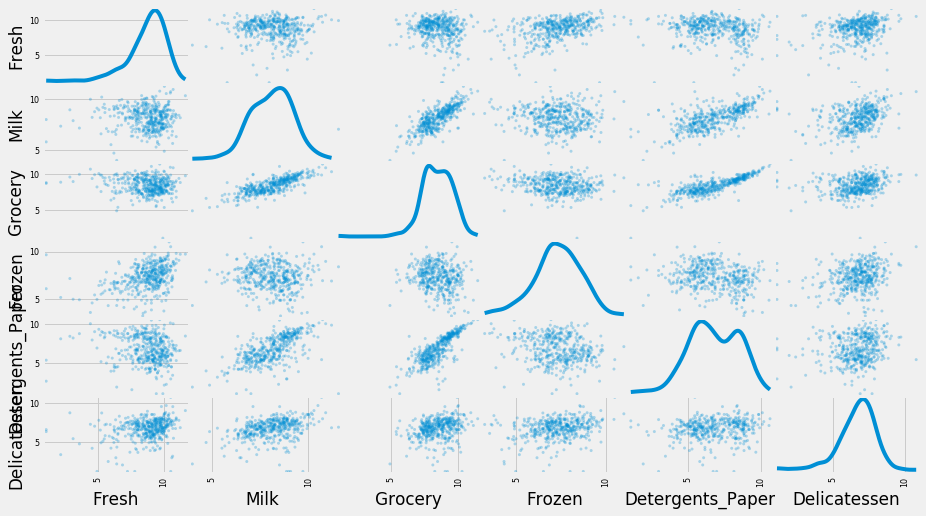

In [26]:
# Scale the data using the natural logarithm
log_data = np.log(data.copy())

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature appears to be normal.

In [38]:
# Display the log-transformed sample data #S1
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,10.180096,10.502956,9.999661,8.547528,8.374938,9.712509
42,9.291920,8.929965,9.613202,5.236442,8.839132,3.828641
127,9.974179,8.887791,9.276596,6.779922,7.777374,7.918992


 As we can see by both the scatter matrix and the sample data frame, the distribution is way more normal. 
 But if we look closer at the density plots of each feature, we can see that in some cases we are now dealing 
 with a slight to strong negative skew. This might have to do with data points that tend to be extreme, so-called outliers.

### Outlier Detection


Used the Interquartile rangle(IQR) plots to know which records are outliers and to deal with them

In [28]:
# For each feature find the data points with extreme high or low values #S1
df_index = []
df_data = []

for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step =  1.5*(Q3-Q1)
    
    # OPTIONAL: Select the indices for data points you wish to remove
    df=log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    df_values = np.asarray(df.index.values)
    df_index.append(df_values)
    df_data.append(df)
    
    # Display the outliers
    print (("Data points considered outliers for the feature '{}':").format(feature))
    print (("Q1='{}' Q3='{}'").format(Q1,Q3))
    print ("Step='{}'".format(step))
    display(data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
################ Own logic ###### 
# Remove the outliers, if any were specified
df_index = np.concatenate(df_index)
outliers =  pd.DataFrame(log_data.loc[df_index], columns = data.keys()).reset_index(drop = True)

#Find unique indexes/customers that had an outlier on more than one feature
df_indexf = pd.DataFrame(df_index)
df_indexf.columns = ['index']
df_indexf['freq'] = df_indexf.groupby('index')['index'].transform('count')
df_if=df_indexf.loc[df_indexf['freq'] >1]
df_unique =df_if['index'].unique()
print
print ("customers who have an outlier on more than one feature") 
print (df_unique)

good_data = log_data.drop(log_data.index[df_unique]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':
Q1='8.048058702214819' Q3='9.73706394795268'
Step='2.533507868606793'


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,85,20959,45828,36,24231,1423
66,9,1534,7417,175,3468,27
81,219,9540,14403,283,7818,156
95,3,2920,6252,440,223,709
96,23,2616,8118,145,3874,217
128,140,8847,3823,142,1062,3
171,200,25862,19816,651,8773,6250
193,180,3485,20292,959,5618,666
218,18,7504,15205,1285,4797,6372
304,161,7460,24773,617,11783,2410


Data points considered outliers for the feature 'Milk':
Q1='7.334981240042021' Q3='8.880480088587671'
Step='2.318248272818475'


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,22925,73498,32114,987,20070,903
98,503,112,778,895,56,132
154,622,55,137,75,7,8
356,22686,134,218,3157,9,548


Data points considered outliers for the feature 'Grocery':
Q1='7.67461620137308' Q3='9.27385367723784'
Step='2.3988562137971394'


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,20398,1137,3,4407,3,975
154,622,55,137,75,7,8


Data points considered outliers for the feature 'Frozen':
Q1='6.609677749172153' Q3='8.175896083178294'
Step='2.3493275010092116'


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,4591,15729,16709,33,6956,433
57,5417,9933,10487,38,7572,1282
65,85,20959,45828,36,24231,1423
145,22039,8384,34792,42,12591,4430
175,2343,7845,11874,52,4196,1697
264,1073,9679,15445,61,5980,1265
325,32717,16784,13626,60869,1272,5609
420,4456,5266,13227,25,6818,1393
429,8607,1750,3580,47,84,2501
439,2787,1698,2510,65,477,52


Data points considered outliers for the feature 'Detergents_Paper':
Q1='5.548101424791306' Q3='8.274340598750195'
Step='4.0893587609383335'


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,20398,1137,3,4407,3,975
161,12434,540,283,1092,3,2233


Data points considered outliers for the feature 'Delicatessen':
Q1='6.011874656932535' Q3='7.506728426547161'
Step='2.2422806544219394'


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,9,1534,7417,175,3468,27
109,1406,16729,28986,673,836,3
128,140,8847,3823,142,1062,3
137,3087,8080,8282,661,721,36
142,37036,7152,8253,2995,20,3
154,622,55,137,75,7,8
183,36847,43950,20170,36534,239,47943
184,327,918,4710,74,334,11
187,2438,8002,9819,6269,3459,3
203,583,685,2216,469,954,18


customers who have an outlier on more than one feature
[ 65  66 128 154  75]


The indexes/customers 65, 66, 128, 154, and 75 had outliers for more than one feature. These points were moved to the outliers list to be removed because their values were considered statisically out of range of the data set, which if included would create bias and add variablity in the model, decreasing the model's predictive accuracy.

## Feature Transformation

### Implementation: PCA

As the data has been scaled to a more normal distribution and has had any necessary outliers removed, we applied PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone.

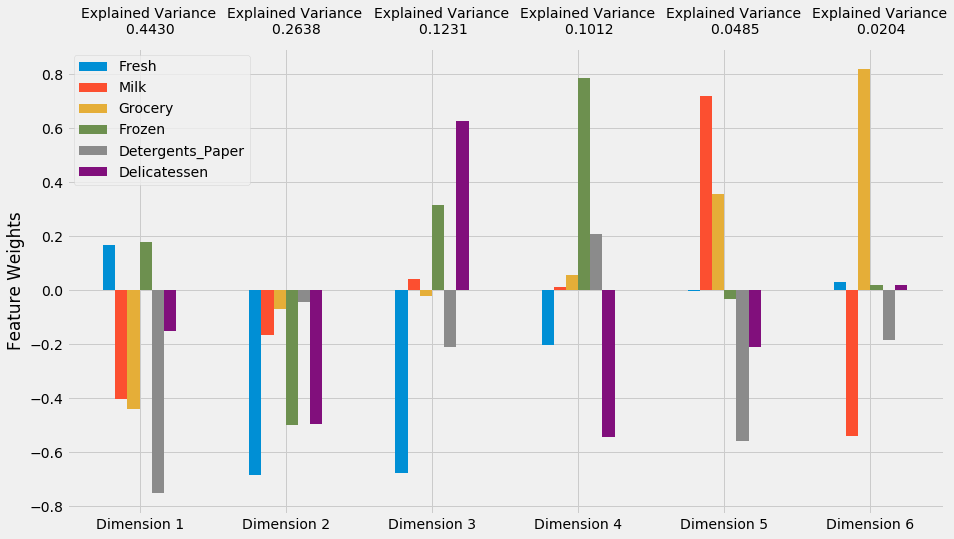

In [29]:
from sklearn.decomposition import PCA #S1

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

In [30]:
# Display cumulative sums of the explained variance ratios
pca_results.cumsum()

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.7068,-0.5184,-0.5686,-0.5088,-0.3223,-0.7938,-0.6440
Dimension 3,0.8299,-1.1958,-0.5284,-0.5283,-0.0073,-1.0055,-0.0154
Dimension 4,0.9311,-1.4001,-0.5156,-0.4726,0.7781,-0.7959,-0.5577
Dimension 5,0.9796,-1.4027,0.2036,-0.1172,0.7450,-1.3541,-0.7669
Dimension 6,1.0000,-1.3735,-0.3366,0.7033,0.7655,-1.5365,-0.7472


Total variance explained by first two PCs: `0.7068`

Total variance explained by first four PCs: `0.9311`

Dimension 1
The first principal component seems to be described primarily by detergents and paper, but also by milk and grocery categories albiet to a lesser degree. Because all of the weights are negative, this suggests that the aforementioned categories vary in a similar manner across the dataset.

Key features: Milk, grocery, detergents and paper.

Dimension 2
The second principal component describes the variance among the three remaining features, fresh, frozen, and deli. These weights, as was the case in the first principal component, all have the same sign signifying they vary together. It is interesting that the first two principal components are both in the opposite direction as the feature vectors which they largely explain, but for the case of dimensionality reduction it does not affect the end results.

Key features: Fresh, frozen, deli.

Dimension 3
Here, we finally see the first divergence in feature weights. Wheras fresh has a large negative weight, deli has a large positive weight. This suggests that the fresh and deli categories are negatively correlated and vary opposite to each other. Whereas the first two principal components made general splits in separating according to the groups of features, we're now starting to make more granular distinctions between observations in our data. Namely, that even though fresh and deli vary together in the second principal component, there is still a distinction to be made between the two categories.

Key features: Fresh, deli.

Dimension 4
The fourth principal component acts largely in a similar manner as the third, making a distinction between frozen and deli and uncovering their negative correlation. However, this appears to be making an even more granular distinction, as the third principal component suggested that frozen and deli varied in the same direction. In the fourth principal component, we realize that this is not necessarily true.

Key features: Frozen, deli.

### Observation
Code below tells how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. We see it is consistent with your initial interpretation of the sample points.

In [31]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.8096,-3.6459,1.0567,-0.5186,0.6999,-0.1811
1,-2.2146,1.7988,-3.2371,0.3088,0.5148,0.0568
2,-1.4761,-1.3871,-0.4123,-1.0784,0.0489,0.1294


### Dimensionality Reduction
We reduced the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In [32]:
# Apply PCA by fitting the good data with only two dimensions #S1
pca = PCA(n_components=2)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform the log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

Here we observed how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [34]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.8096,-3.6459
1,-2.2146,1.7988
2,-1.4761,-1.3871


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components.  In addition, the biplot shows the projection of the original features along the components. From this we can interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

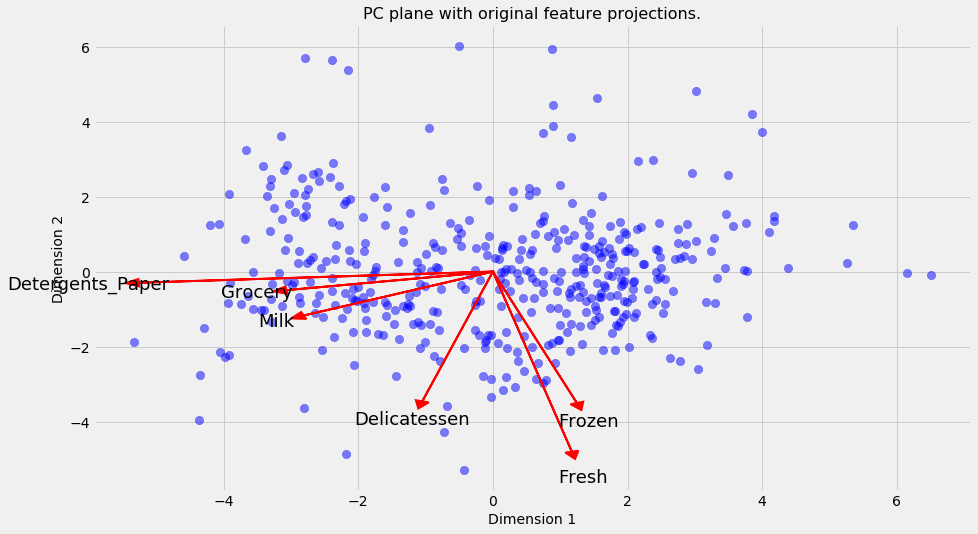

In [39]:
# Create a biplot #Own Logic
vs.biplot(good_data, reduced_data, pca)

`Fresh`, `Frozen`, and `Delicatessen` are the features most strongly correlated with the `Dimension 1`.

`Detergents_Paper`, `Grocery`, and `Milk` are the features most strongly correlated with the `Dimension 2`.

Next we will Use K-Means clustering algorithm  to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

###  Clustering 
When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. Silhoutte score for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [42]:
from sklearn.cluster import KMeans # Own code
from sklearn.metrics import silhouette_score

# Use silhouette score to find optimal number of clusters to segment the data
num_clusters = np.arange(2,10)
kmeans_results = {}
for size in num_clusters:
    kmeans = KMeans(n_clusters = size).fit(reduced_data)
    preds = kmeans.predict(reduced_data)
    kmeans_results[size] = silhouette_score(reduced_data, preds)

best_size = max(kmeans_results, key=kmeans_results.get)

# Build a model with the optimal number of clusters
optimized_kmeans = KMeans(n_clusters = best_size, random_state = 0).fit(reduced_data)
# Assign data to clusters
kmeans_preds = optimized_kmeans.predict(reduced_data)
print (kmeans_preds)
# Reports the centers of each cluster
kmeans_centers = optimized_kmeans.cluster_centers_
# Store cluster assignment for the three samples we've been manually examining
kmeans_sample_preds = optimized_kmeans.predict(pca_samples)
    # Report the best silhouette score 
kmeans_score = silhouette_score(reduced_data, preds)

kmeans_assignment = optimized_kmeans.predict(reduced_data)
sample_kmeans_assignment = optimized_kmeans.predict(pca_samples)

[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0
 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1
 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0
 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0]


In [43]:
display(kmeans_results)

{2: 0.42628101546910846,
 3: 0.39640192996232043,
 4: 0.3320225307732876,
 5: 0.34999779752629756,
 6: 0.36515878089339626,
 7: 0.3651515355283027,
 8: 0.352640592099046,
 9: 0.34757202462331604}

It appears that according to the silhoutte scores we should segment our customers into 2 groups 

### Cluster Visualization

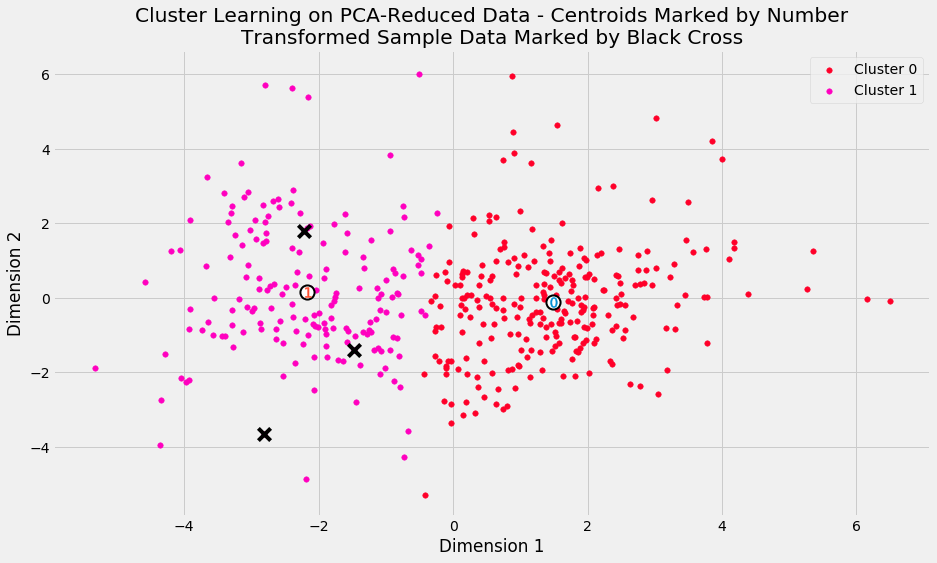

In [129]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, kmeans_preds, kmeans_centers, pca_samples)

We can observe clients which may exist on the boundary between the two assignments and be equally likely to be assigned to either segment.

This might be useful if the distributor wishes to change an aspect of their service that would have a strong positive effect for one segment and a strong negative effect for the other segement. To avoid negative effects, the distributor could set a limit and only roll out the new service to clients who have a strong probability of belonging to the segment that would respond positively.

### Data Recovery

In [44]:
# Inverse transform the centers #S1
log_centers = pca.inverse_transform(kmeans_centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(kmeans_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8867.0,1897.0,2477.0,2088.0,294.0,681.0
Segment 1,4005.0,7900.0,12104.0,952.0,4561.0,1036.0


Average purchase costs for each category:
Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64


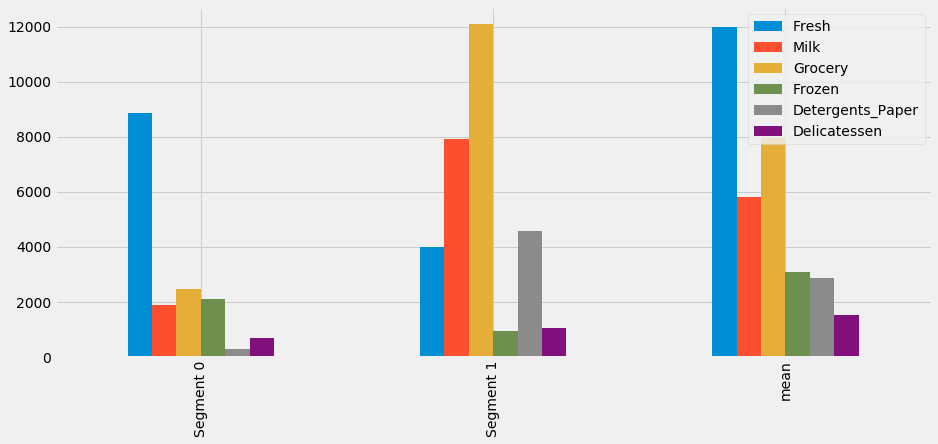

In [46]:
print ('Average purchase costs for each category:') # Own code
print (data.sum() / 440)

# Visualize samples
import seaborn as sns
true_centers_bar = true_centers.append(data.describe().loc['mean'])
_ = true_centers_bar.plot(kind='bar', figsize=(14,6))

Segmentation 0 should be restaurant. 'fresh' and 'frozen' are two spendings that are larger than median.

Segnemtation 1 should be retailers. 'milk', 'grocery' and 'detergents paper' are above the median.

In [132]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print ("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


The silhouette score aided us quite well in choosing the proper number of segments to group the data into. Further, the clustering algorithm generally assigns clients to the proper channel segmentation. The clustering algoritm does make a few mistakes in classifying customers, however, it is likely that increased the number of principal components used in our analysis would allow us to make more accurate predictions.